In [1]:
#!pip install sdv
#!pip install ctgan

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import pandas as pd
import os
import sqlite3

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

path_prefix = ''

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    #path_prefix = '/content/drive/My Drive/eICU_gan/eICU_gan_data.db'
    path_prefix = '/content/drive/My Drive/eICU_gan/'

else:
    path_prefix = '../data/'

In [3]:
conn_eICU = sqlite3.connect(path_prefix + 'eICU_gan_data.db')

In [16]:
'''sql = """SELECT * FROM patient"""
data_patients = pd.read_sql(sql, conn_eICU)
data_patients.head()'''

'sql = """SELECT * FROM patient"""\ndata_patients = pd.read_sql(sql, conn_eICU)\ndata_patients.head()'

# Try with age unit type

In [12]:
npy_age_unittype = np.load(path_prefix + 'eICU_age_unittype.npy', allow_pickle=True)
df_ages = pd.DataFrame(zip(np.asarray(npy_age_unittype[:,0].flatten().tolist()).flatten(), np.asarray(npy_age_unittype[:,1].flatten().tolist()).flatten()), columns=['age','unit'])

In [13]:
df_ages.head()

,age,unit
0,59,CTICU
1,55,CTICU
2,72,Cardiac ICU
3,49,CTICU
4,49,CTICU


In [17]:
import sys
sys.path.insert(0,'..')

from dataprep import create_eICU_data
os.getcwd()

'c:\\Users\\dianam\\Documents\\jlab_datascience\\PlayGround\\DS6050\\eICU_gan\\gan_work'

In [23]:
# create data set without 90 or greater since that was a category flattened
df_ages_filtered = df_ages.query("age < 90")

df_ages_filtered = create_eICU_data.minmax_scale_columns(df_ages_filtered, ['age'])
print(df_ages_filtered.head())


# Create tf.data.Dataset: suffle, batch, prefetch
dataset = tf.data.Dataset.from_tensor_slices((all_ages, all_labels))
dataset = dataset.shuffle(buffer_size=200).batch(64).prefetch(1)


        age         unit
0  0.558824        CTICU
1  0.500000        CTICU
2  0.750000  Cardiac ICU
3  0.411765        CTICU
4  0.411765        CTICU


In [24]:
from ctgan import CTGANSynthesizer

In [27]:
df_ages_filtered[['age', 'unit']][0:5]

,age,unit
0,0.558824,CTICU
1,0.500000,CTICU
2,0.750000,Cardiac ICU
3,0.411765,CTICU
4,0.411765,CTICU


In [28]:
from sdv.tabular import CTGAN

In [29]:
ctgan = CTGAN(verbose=True, epochs = 2000, batch_size = 40)
ctgan.fit(df_ages_filtered[['age', 'unit']])

Epoch 1, Loss G:  1.0093,Loss D: -0.0552


C:\Users\dianam\AppData\Local\Programs\Python\Python39\lib\site-packages\ctgan\data_transformer.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = data[column_name].to_numpy().flatten()


Epoch 2, Loss G:  1.1083,Loss D: -0.1067
Epoch 3, Loss G:  0.9671,Loss D: -0.0622
Epoch 4, Loss G:  0.9749,Loss D: -0.1684
Epoch 5, Loss G:  0.8875,Loss D: -0.2188
Epoch 6, Loss G:  1.1019,Loss D: -0.3255
Epoch 7, Loss G:  0.7584,Loss D:  0.1261
Epoch 8, Loss G:  0.8470,Loss D:  0.1520
Epoch 9, Loss G:  0.6416,Loss D: -0.2209
Epoch 10, Loss G:  0.7320,Loss D: -0.6323
Epoch 11, Loss G:  0.9150,Loss D: -0.4339
Epoch 12, Loss G:  0.3124,Loss D:  0.0466
Epoch 13, Loss G:  0.5459,Loss D:  0.0579
Epoch 14, Loss G:  0.2195,Loss D: -0.0234
Epoch 15, Loss G:  0.2145,Loss D: -0.1708
Epoch 16, Loss G:  0.3940,Loss D:  0.2094
Epoch 17, Loss G:  0.4443,Loss D: -0.5069
Epoch 18, Loss G:  0.2796,Loss D: -0.0493
Epoch 19, Loss G:  0.2077,Loss D: -0.0855
Epoch 20, Loss G:  0.2503,Loss D: -0.0291
Epoch 21, Loss G:  0.4231,Loss D: -0.0998
Epoch 22, Loss G:  0.4411,Loss D:  0.3437
Epoch 23, Loss G:  0.3072,Loss D: -0.0262
Epoch 24, Loss G:  0.2953,Loss D:  0.1945
Epoch 25, Loss G:  0.4024,Loss D:  0.6247


In [30]:
samples = ctgan.sample(df_ages_filtered.shape[0])

In [31]:
samples['data'] = 'GAN'

In [32]:
df_ages_filtered['data'] = 'Real'

In [33]:
both = pd.concat([samples, df_ages_filtered[['age', 'unit', 'data']]])

In [34]:
csICU = both[both['unit'] == 'CSICU'].reset_index().drop('index', axis = 1)

In [35]:
ctICU = both[both['unit'] == 'CTICU'].reset_index().drop('index', axis = 1)

In [36]:
cardiacICU = both[both['unit'] == 'Cardiac ICU'].reset_index().drop('index', axis = 1)

<function matplotlib.pyplot.show(close=None, block=None)>

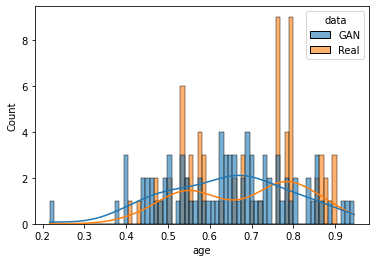

In [37]:
sns.histplot(data = csICU, x='age', hue='data', bins=70, color='orange', kde=True, alpha=0.6)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

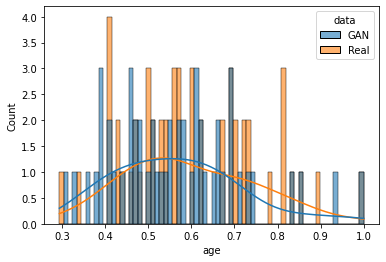

In [38]:
sns.histplot(data = ctICU, x='age', hue='data', bins=70, color='orange', kde=True, alpha=0.6)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

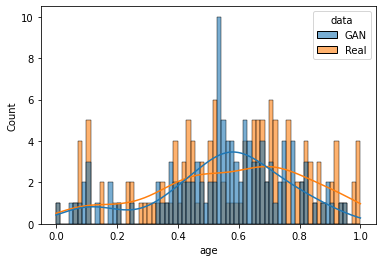

In [39]:
sns.histplot(data = cardiacICU, x='age', hue='data', bins=70, color='orange', kde=True, alpha=0.6)
plt.show

In [41]:
samples.to_csv(path_prefix + 'CTGAN_age_unittype.csv', index=False)